In [270]:
import json, os, glob
from PIL import Image, ImageDraw
import numpy as np
from PIL.ImageColor import getrgb

In [271]:
class_dict = {'NFL':13, 'GCL+IPL':5, 'INL':17, 'OPL':2,'ONL':22,'Elipsoid Zone':9,'RPE':3,'Choroid':31}

In [ ]:
json_file = '/home/khamituly/Documents/Diploma work/labels_8_layer_2022-06-08-03-14-52.json'
original_images = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/X/'
result_save = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/Y_test/'

In [272]:
all_labels = json.load(open(json_file))

In [273]:
rawlist = all_labels.keys()
print(all_labels.keys())

dict_keys(['06 OS - Copy.jpeg', '108 OD - Copy.jpeg', '22 OD - Copy.jpeg', '26 OD - Copy.jpeg', '31 OD - Copy.jpeg', '33 OD - Copy.jpeg', '34 OS - Copy.jpeg', '50 OD - Copy.jpeg', '56 OS - Copy.jpeg', '64 OD - Copy.jpeg'])


In [275]:
# def get_data(data, X,Y,L):
def get_data(data):

    X = []; Y = []; L=[] #pre-allocate lists to fill in a for loop
    for k in data['regions']: #cycle through each polygon
        # get the x and y points from the dictionary
        X.append(data['regions'][k]['shape_attributes']['all_points_x'])
        Y.append(data['regions'][k]['shape_attributes']['all_points_y'])
        L.append(data['regions'][k]['region_attributes']['label'])
    return Y,X,L #image coordinates are flipped relative to json coordinates

In [280]:
def get_mask(X, Y, nx, ny, L, class_dict):
    # get the dimensions of the image
    mask = np.zeros((nx,ny))

    for y,x,l in zip(X,Y,L):
        # the ImageDraw.Draw().polygon function we will use to create the mask
        # requires the x's and y's are interweaved, which is what the following
        # one-liner does
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()

        # create a mask image of the right size and infill according to the polygon
        size = (nx, ny)
        if nx>ny:
           x,y = y,x
           img = Image.new("L",  (nx, ny), 0)
        elif ny>nx:
           img = Image.new("L", (ny,nx), 0)
        else:
           img = Image.new("L", (nx, ny),  0)

        ImageDraw.Draw(img).polygon(polygon, fill = 1, outline = 1)
        # turn into a numpy array
        m = np.flipud(np.rot90(np.array(img)))

        try:
            mask[m==1] = class_dict[l]
        except:
            mask[m.T==1] = class_dict[l]  

         # mask[m==1] = class_dict[l]

    return mask

In [282]:
def rescale(dat,mn,mx):
    '''
    rescales an input dat between mn and mx
    '''
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

In [283]:
for name in rawlist:
    
    new_path = original_images+name
    image = Image.open(new_path)
    nx, ny, nz = np.shape(image)
    
    X, Y, L = get_data(all_labels[name])

    mask = get_mask(X, Y, nx, ny, L, class_dict)

    mask = Image.fromarray(rescale(mask,0,255)).convert('RGB')
    mask.save(result_save+name.replace('imagery','labels'), format='PNG')


In [284]:
import cv2

In [285]:
img = cv2.imread(result_save+'33 OD - Copy.jpeg')
img = cv2.resize(img,(640,640), interpolation = cv2.INTER_NEAREST)

In [286]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = img.shape
train_masks_reshaped = img.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [287]:

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
np.unique(train_masks_input)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [288]:
np.unique(img)

array([  0,  16,  24,  41,  74, 106, 139, 180, 255], dtype=uint8)

In [289]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(result_save):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (640,640), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [290]:
for i in range(10):
    print(np.unique(train_masks[i]),'  label'+str(i))


[  0  16  24  41  74 106 139 180 255]   label0
[  0  16  24  41  74 106 139 180 255]   label1
[  0  16  24  41  74 106 139 180 255]   label2
[  0  16  24  41  74 106 139 180 255]   label3
[  0  16  24  41  74 106 139 180 255]   label4
[  0  16  24  41  74 106 139 180 255]   label5
[  0  16  24  41  74 106 139 180 255]   label6
[  0  16  24  41  74 106 139 180 255]   label7
[  0  16  24  41  74 106 139 180 255]   label8
[  0  16  24  41  74 106 139 180 255]   label9


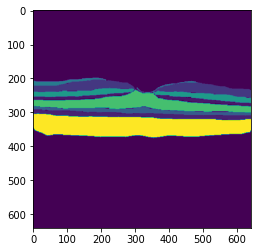

In [291]:
from matplotlib import pyplot as plt

plt.imshow(train_masks[1])

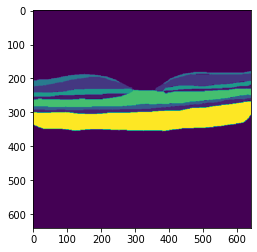

In [292]:
from matplotlib import pyplot as plt

plt.imshow(train_masks[3])